# Research on Sweet Lift Taxi - Time Series

* <b>Sweet Lift Taxi company has collected historical data on taxi orders at airports. </b>


* <b>To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour.</b> 


* <b><font color='red'>The Task is to: Build a model for such a prediction.</font></b>


* <b>The RMSE metric on the test set should <u>not be more than 48.</u></b>


* <b>Project instructions</b>

  1. Download the data and resample it by one hour.
  2. Analyze the data.
  3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
  4. Test the data using the test sample and provide a conclusion.



* <b>Data description</b>

  - The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Initialization

In [1]:
import pandas as pd
import numpy as np
import datetime
import math
import statistics
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from IPython import display

from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

## Preparation

In [2]:
df = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.isna().sum()

num_orders    0
dtype: int64

In [5]:
#df.sort_index(inplace=True)

In [6]:
df_hour = df.copy()

In [7]:
df_hour = df_hour.resample('1H').sum()
df_hour.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
df_hour.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Analysis

In [9]:
print(df_hour.index.min())
print(df_hour.index.max())

2018-03-01 00:00:00
2018-08-31 23:00:00


### Seasonality

<AxesSubplot:xlabel='datetime'>

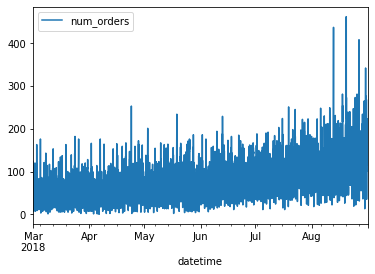

In [10]:
df_hour.plot()

* On a daily outlook from Mar to JUN, the distribution of the data look similar each month 
  * there is a peak on May and another one on Jun 
* On August there are several peaks, there were a significant increase 
  * August is a summer month on so many country, and people tend to go out frequently during summer 
  * It is likely that the Sweet Lift Taxi belongs to one of those countries 

In [11]:
decomposed = seasonal_decompose(df_hour)

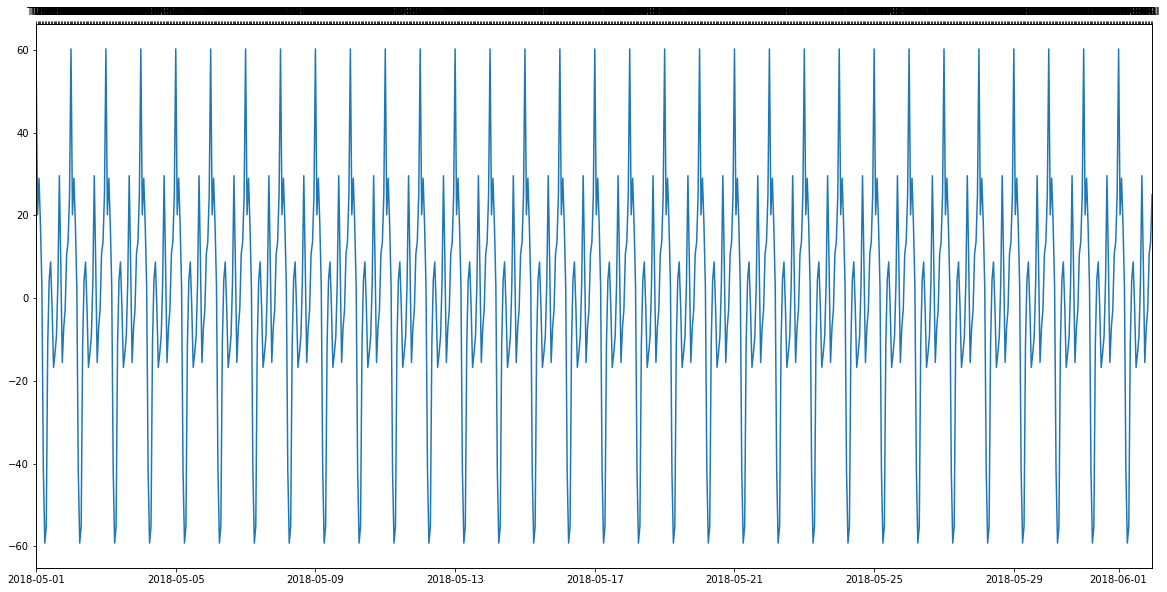

In [12]:
Y = decomposed.seasonal['2018-05-01':'2018-06-01'].values
x = decomposed.seasonal['2018-05-01':'2018-06-01'].index
weekday_map= {0:'MON', 1:'TUE', 2:'WED', 3:'THU', 4:'FRI', 5:'SAT', 6:'SUN'}
dow = decomposed.seasonal['2018-05-01':'2018-06-01'].index.dayofweek.map(weekday_map)

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax2.set_xticks(np.arange(len(x)), minor=False)
ax2.set_xticklabels(dow)
ax1.set_xlim(min(x), max(x))
ax1.plot(x, Y)

**Graph look very interseting, it is a symmetric graph actually**

### Month aggregation

<AxesSubplot:xlabel='datetime'>

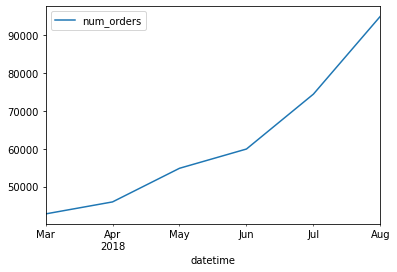

In [13]:
data_month = df_hour.resample('1M').sum()
data_month.plot()

* Order numbers keep on increasing by time the highest values are on August as explained on the previous step
* Min is the first month, max is the last month of the dataset (March and August respectively)

## Training

In [14]:
train, test = train_test_split(df_hour, shuffle=False, test_size=0.1)

In [15]:
train_y = train['num_orders']
train_X = train.drop('num_orders', axis=1)
test_y = test['num_orders']
test_X = test.drop('num_orders', axis=1)

### Base model - Constant

In [16]:
pred_median = np.ones(test_y.shape) * train_y.median()
print('MAE: {:.2f}'.format(mean_absolute_error(test_y, pred_median)))
print('RMSE: {:.2f}'.format(math.sqrt(mean_squared_error(test_y, pred_median))))

MAE: 70.79
RMSE: 87.15


### Previous Value model

In [17]:
pred_previous = test_y.shift()
pred_previous.iloc[0] = train_y.iloc[-1]
print('MAE: {:.2f}'.format(mean_absolute_error(test_y, pred_previous)))
print('RMSE: {:.2f}'.format(math.sqrt(mean_squared_error(test_y, pred_previous))))

MAE: 44.97
RMSE: 58.86


#### Making data stationary

df_hour -= df_hour.shift()

df_hour.info()

#### Feature Generation

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['year'] = new_data.index.year
    new_data['month'] = new_data.index.month
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_data

In [19]:
df_hour = make_features(df_hour, 22, 7)

In [20]:
df_hour.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Data split

In [21]:
train, test = train_test_split(df_hour, shuffle=False, test_size=0.1)
train = train.dropna()
train_y = train['num_orders']
train_X = train.drop('num_orders', axis=1)
test_y = test['num_orders']
test_X = test.drop('num_orders', axis=1)

**Using cross validation with TimeSeriesSplit**

In [23]:
def cross_val(model_is,X,y):
    tss = TimeSeriesSplit(n_splits=5).split(X)
    res_scores = cross_val_score(model_is, X,y, cv=tss,scoring='neg_root_mean_squared_error')
    res_scores = abs(res_scores)
    return res_scores

### Model 1 - Linear Regression

In [25]:
%%time

model_1 = LinearRegression()
model_1_rmse = (cross_val(model_1, train_X, train_y)).round(2)
print(model_1_rmse)
print('Mean of the RMSE - model Linear Regression',statistics.mean(model_1_rmse).round(2))

[29.66 27.57 28.11 30.02 36.63]
Mean of the RMSE - model Linear Regression 30.4
CPU times: user 255 ms, sys: 309 ms, total: 564 ms
Wall time: 563 ms


### Model 2 - Random Forest Regressor

In [26]:
%%time

model_2 = RandomForestRegressor(random_state=12345)
model_2_rmse = ( cross_val(model_2, train_X, train_y)).round(2)
print(model_2_rmse)
print('Mean of the RMSE - model Random Forest Regressor',statistics.mean(model_2_rmse).round(2))

[24.02 24.97 26.17 27.65 35.51]
Mean of the RMSE - model Random Forest Regressor 27.66
CPU times: user 10.9 s, sys: 51.5 ms, total: 11 s
Wall time: 11.1 s


### Model 3 - Cat Boost

In [27]:
%%time
model_3 = CatBoostRegressor(silent=True) 
model_3_rmse = (cross_val(model_3, train_X, train_y)).round(2)
print(model_3_rmse)
print('Mean of the RMSE - model Cat Boost Regressor',statistics.mean(model_3_rmse).round(2))

Learning rate set to 0.03836
0:	learn: 29.3076904	total: 52.8ms	remaining: 52.7s
1:	learn: 28.9030400	total: 57.5ms	remaining: 28.7s
2:	learn: 28.5304380	total: 62.2ms	remaining: 20.7s
3:	learn: 28.1214940	total: 66.8ms	remaining: 16.6s
4:	learn: 27.7097239	total: 71.6ms	remaining: 14.2s
5:	learn: 27.4064783	total: 76.2ms	remaining: 12.6s
6:	learn: 27.1420153	total: 81.2ms	remaining: 11.5s
7:	learn: 26.8112589	total: 85.9ms	remaining: 10.7s
8:	learn: 26.5196855	total: 90.6ms	remaining: 9.97s
9:	learn: 26.2207389	total: 95.2ms	remaining: 9.43s
10:	learn: 25.9177036	total: 100ms	remaining: 8.99s
11:	learn: 25.6173848	total: 105ms	remaining: 8.62s
12:	learn: 25.3160304	total: 109ms	remaining: 8.31s
13:	learn: 25.0700999	total: 114ms	remaining: 8.05s
14:	learn: 24.7662315	total: 119ms	remaining: 7.82s
15:	learn: 24.5339995	total: 124ms	remaining: 7.62s
16:	learn: 24.2798479	total: 129ms	remaining: 7.45s
17:	learn: 24.0202046	total: 134ms	remaining: 7.29s
18:	learn: 23.8127929	total: 137ms	

### Model 4 - Light GBM

In [28]:
%%time

model_4 = LGBMRegressor(random_seed=12345)
model_4_rmse = ( cross_val(model_4, train_X, train_y)).round(2)
print(model_4_rmse)
print('Mean of the RMSE - model Light GBM Regressor',statistics.mean(model_4_rmse).round(2))

[24.18 24.71 26.05 27.43 34.37]
Mean of the RMSE - model Light GBM Regressor 27.35
CPU times: user 13min 11s, sys: 11 s, total: 13min 22s
Wall time: 13min 28s


### Model 5 - XGBoost Regressor

In [29]:
%%time

model_5 = XGBRegressor(random_state=12345)
model_5_rmse = ( cross_val(model_5, train_X, train_y)).round(2)
print(model_5_rmse)
print('Mean of the RMSE - model XGBoost Regressor',statistics.mean(model_5_rmse).round(2))

[25.06 25.27 27.49 28.85 34.78]
Mean of the RMSE - model XGBoost Regressor 28.29
CPU times: user 10min 11s, sys: 5.77 s, total: 10min 17s
Wall time: 10min 22s


## Testing

method to plot scatter graph for the predicted values vs the actual values

In [30]:
def plotGraph(y_test,y_pred,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    fig = plt.figure()
    plt.scatter(range(len(y_test)), y_test, color='blue')
    plt.scatter(range(len(y_pred)), y_pred, color='red')
    plt.title(regressorName)
    fig.legend(labels = ('Actual','Predicted'),loc='upper right')
    plt.show()
    return

**Test target**

* On the task we have to predict numbe of orders for the next hour
* Shifting the actual target set (to the previous one), and comparing it with the predicted values for the original set(unshifted)
* in other way it is as predicting orders for the next hour

In [41]:
test_y_shift = test_y.shift()
test_y_shift.iloc[0] = train_y.iloc[-1]

***model 1 - Linear Regression***

In [42]:
%%time
model_1.fit(train_X, train_y)
pred_test_1 = model_1.predict(test_X)
print('RMSE on test: {:.2f}'.format(math.sqrt(mean_squared_error(test_y, pred_test_1))))

RMSE on test: 51.05
CPU times: user 52.4 ms, sys: 39.3 ms, total: 91.6 ms
Wall time: 47.8 ms


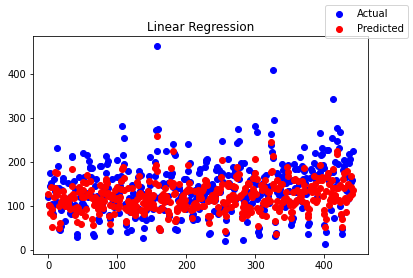

In [43]:
plotGraph(test_y_shift,pred_test_1,'Linear Regression')

**model 2 - Random Forest**

In [44]:
%%time
model_2.fit(train_X, train_y)
pred_test_2 = model_2.predict(test_X)
print('RMSE on test: {:.2f}'.format(math.sqrt(mean_squared_error(test_y, pred_test_2))))

RMSE on test: 49.86
CPU times: user 4.66 s, sys: 0 ns, total: 4.66 s
Wall time: 4.68 s


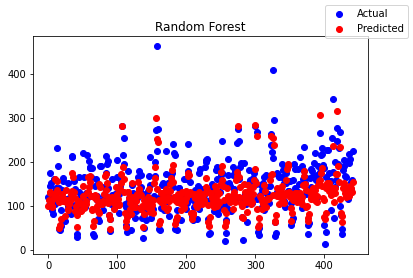

In [45]:
plotGraph(test_y_shift,pred_test_2,'Random Forest')

***model 3 - Cat Boost***

In [46]:
%%time
model_3.fit(train_X, train_y)
pred_test_3 = model_3.predict(test_X)
print('RMSE on test: {:.2f}'.format(math.sqrt(mean_squared_error(test_y, pred_test_3))))

Learning rate set to 0.050872
0:	learn: 38.0195086	total: 6.1ms	remaining: 6.09s
1:	learn: 37.3665353	total: 12ms	remaining: 6.01s
2:	learn: 36.7302275	total: 17.7ms	remaining: 5.87s
3:	learn: 36.2196888	total: 23.5ms	remaining: 5.86s
4:	learn: 35.6994998	total: 29.7ms	remaining: 5.91s
5:	learn: 35.2667277	total: 35.4ms	remaining: 5.86s
6:	learn: 34.8267122	total: 41.2ms	remaining: 5.84s
7:	learn: 34.4121537	total: 47.6ms	remaining: 5.9s
8:	learn: 33.9835159	total: 52.8ms	remaining: 5.81s
9:	learn: 33.6129528	total: 58.6ms	remaining: 5.8s
10:	learn: 33.2291546	total: 64.3ms	remaining: 5.78s
11:	learn: 32.8984644	total: 70ms	remaining: 5.76s
12:	learn: 32.5586330	total: 75.3ms	remaining: 5.72s
13:	learn: 32.2395960	total: 81.2ms	remaining: 5.71s
14:	learn: 31.9564031	total: 87ms	remaining: 5.71s
15:	learn: 31.7037182	total: 92.8ms	remaining: 5.71s
16:	learn: 31.4350472	total: 98.8ms	remaining: 5.71s
17:	learn: 31.1489886	total: 104ms	remaining: 5.68s
18:	learn: 30.8988896	total: 110ms	r

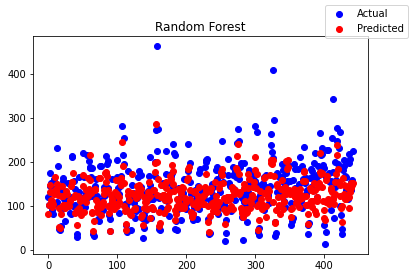

In [47]:
plotGraph(test_y_shift,pred_test_3,'Random Forest')

**Model 4 - Light GBM**

In [48]:
%%time
model_4.fit(train_X, train_y)
pred_test_4 = model_4.predict(test_X)
print('RMSE on test: {:.2f}'.format(math.sqrt(mean_squared_error(test_y, pred_test_4))))

RMSE on test: 44.18
CPU times: user 4min 12s, sys: 3.04 s, total: 4min 15s
Wall time: 4min 20s


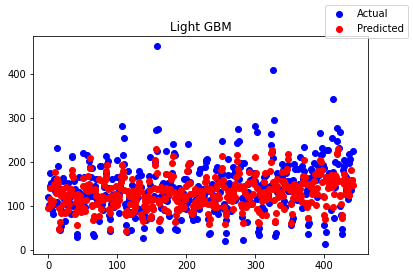

In [49]:
plotGraph(test_y_shift,pred_test_4,'Light GBM')

**Model 5 - XGBoost** 

In [50]:
%%time
model_5.fit(train_X, train_y)
pred_test_5 = model_5.predict(test_X)
print('RMSE on test: {:.2f}'.format(math.sqrt(mean_squared_error(test_y, pred_test_5))))

RMSE on test: 48.25
CPU times: user 2min 15s, sys: 1.24 s, total: 2min 16s
Wall time: 2min 17s


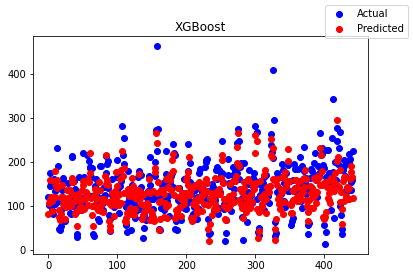

In [51]:
plotGraph(test_y_shift,pred_test_5,'XGBoost')

**Light GBM has an outstanding RMSE score, take more time but gives reliable results**

* from the graphs above we can see that the predicted values are more scattered(for CatBoost,Light GBM, XGBoost) in comparison to the Linear regression and random forest 

## Conclusions

* On the first stage, we observed the data:
  * there are 26496 entries with 2 attributes (date and num of orders)
  * No null values  
  * we perform resampling for 1H, in order to get information in a way to to let us perform predictions about the orders numbers

* On the second stage, we observed the data distribution 
  * On a daily outlook 
     * from Mar to JUN, the distribution of the data look similar each month 
     * On August there are several peaks, there were a significant increase 
   
  * Monthly plot: we obseved increasing of th orders as times goes by 
     * The August peaks might be due to seasonal behaviour of going out for entertainment, recreation ..etc 
      
  * We got a very intersting graph for the seasonal decompose of May
     

* On the training model stage 
   * for the constant and previous model we got high values of MAE and RMSE 
   * performed data stationary and making features in order to run other models and get more accurate results 
   * Linear regression: save time and has good metric results
   * Random Forest: save time and has excellent metric results
   * Cat Boost: save time and has great metric results(the lowest)
   * Light GBM: takes a little more time and has great metric results 
   * XG Boost: takes time and good metric results
   * Ranks: (best to worst)
      * CatBoost
      * Light GBM
      * Random Forest
      * XGBoost 
      * Linear Regression

* On the testing model stage 
   * Light GBM performed the best on the test set, it is considered as the best model
   * Here Light GBM beats CatBoost and XGBoost beats Random Forest
   * Ranks: (best to worst)
      * Light GBM
      * CatBoost
      * XGBoost 
      * Random Forest
      * Linear Regression